### Model Portfolio Max Sharpe Ratio

In [161]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from dotenv import load_dotenv
import os

# -----------------------------
# Setup & MT5 initialization
# -----------------------------
load_dotenv()
login = int(os.getenv("ACG_MT5_LOGIN"))
password = os.getenv("ACG_MT5_PASSWORD")
server = os.getenv("ACG_MT5_SERVER")

if not mt5.initialize(login=login, password=password, server=server):
    print("initialize() failed, error code =", mt5.last_error())
    quit()

# -----------------------------
# Config
# -----------------------------
risk_free_rate = 0.0

# FX pairs needed to convert index returns to USD
fx_map = {
    "GER30.pro": "EURUSD.pro",
    "JPN225.pro": "USDJPY.pro",   # flip sign
    "HK50.pro": "USDHKD.pro",     # flip sign
    "UK100.pro": "GBPUSD.pro",
    "EUSTX50.pro": "EURUSD.pro"
}

# -----------------------------
# Helpers
# -----------------------------
def fetch_mt5_data(symbol, days=60):
    utc_from = pd.Timestamp.now() - pd.Timedelta(days=days)
    rates = mt5.copy_rates_from(symbol, mt5.TIMEFRAME_D1, utc_from, days)
    if rates is None:
        raise ValueError(f"Failed to fetch data for {symbol}")
    df = pd.DataFrame(rates)
    df["time"] = pd.to_datetime(df["time"], unit="s")
    df.set_index("time", inplace=True)
    return df

def calculate_log_returns(prices: pd.Series) -> pd.Series:
    return np.log(prices / prices.shift(1)).dropna()

# -----------------------------
# Load expected returns
# -----------------------------
# ai_factor_signal_acg.csv:  asset \t factor_signal
expected_returns_df = pd.read_csv("ai_factor_signal_acg.csv", sep="\t", header=None)
expected_returns_df.columns = ["asset", "factor_signal"]

# -----------------------------
# Z-score the factor signals
# -----------------------------
mean_signal = expected_returns_df["factor_signal"].mean()
std_signal = expected_returns_df["factor_signal"].std()

expected_returns_df["zscore_signal"] = (expected_returns_df["factor_signal"] - mean_signal) / std_signal

# Convert to dict
expected_returns_dict = dict(zip(expected_returns_df["asset"], expected_returns_df["zscore_signal"]))

symbols = list(expected_returns_dict.keys())

# -----------------------------
# Fetch price data for assets
# -----------------------------
data = {symbol: fetch_mt5_data(symbol) for symbol in symbols}

# -----------------------------
# Fetch FX data and compute FX log returns
# -----------------------------
fx_symbols = set(fx_map[s] for s in symbols if s in fx_map)
fx_data = {fx: fetch_mt5_data(fx) for fx in fx_symbols}

fx_returns = {}
for fx, df_fx in fx_data.items():
    lr = calculate_log_returns(df_fx["close"])

    # If pair is quoted as USDXXX (e.g., USDJPY, USDHKD), flip sign to get XXXUSD log return
    if fx.startswith("USD"):
        lr = -lr  # log(1/x) = -log(x)

    fx_returns[fx] = lr

# -----------------------------
# Compute USD-adjusted log returns for all assets
# -----------------------------
asset_returns = {}

for symbol in symbols:
    idx_lr = calculate_log_returns(data[symbol]["close"])

    if symbol in fx_map:
        fx_symbol = fx_map[symbol]
        fx_lr = fx_returns[fx_symbol]

        # Align index and FX by date
        combined = pd.concat([idx_lr, fx_lr], axis=1, join="inner")
        combined.columns = ["idx", "fx"]

        # USD-adjusted return: r_usd = r_index_local + r_fx
        asset_returns[symbol] = combined["idx"] + combined["fx"]
    else:
        # Already in USD terms
        asset_returns[symbol] = idx_lr

# -----------------------------
# Build aligned returns matrix
# -----------------------------
returns = pd.DataFrame(asset_returns).dropna(how="any")

# -----------------------------
# Covariance matrix (daily, log returns)
# -----------------------------
cov_matrix = returns.cov()

# Expected daily returns vector (assumed to be in USD terms already)
expected_returns = np.array([expected_returns_dict[symbol] for symbol in symbols])
expected_returns = expected_returns * returns.std().values  # scale by asset volatilities

# -----------------------------
# Max Sharpe optimization
# -----------------------------
def max_sharpe_ratio(expected_returns, cov_matrix, risk_free_rate=0.0):
    num_assets = len(expected_returns)

    def neg_sharpe(weights):
        port_ret = np.dot(weights, expected_returns)
        port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(port_ret - risk_free_rate) / port_vol

    constraints = [{"type": "eq", "fun": lambda w: np.sum(w) - 1}]
    bounds = [(-1, 1)] * num_assets  # allow shorting; change to (0,1) for long-only
    init_guess = np.ones(num_assets) / num_assets

    result = minimize(neg_sharpe, init_guess, bounds=bounds, constraints=constraints)

    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")

    weights = result.x
    daily_ret = np.dot(weights, expected_returns)
    daily_vol = np.sqrt(weights.T @ cov_matrix @ weights)

    return weights, daily_ret, daily_vol

# -----------------------------
# Run optimization
# -----------------------------
weights, daily_port_return, daily_port_vol = max_sharpe_ratio(
    expected_returns, cov_matrix, risk_free_rate=risk_free_rate
)

# -----------------------------
# Export optimal weights
# -----------------------------
weights_df = pd.DataFrame({
    "Symbol": symbols,
    "Weight": weights
})
weights_df.to_csv("acg_optimal_portfolio_weights.csv", header=False, index=False)
print("\nWeights exported to acg_optimal_portfolio_weights.csv")

# -----------------------------
# Annualized statistics (using daily log returns)
# -----------------------------
annual_port_return = (1 + daily_port_return)**252 - 1
annual_port_vol = daily_port_vol * np.sqrt(252)
annual_sharpe = (annual_port_return - risk_free_rate) / annual_port_vol

# -----------------------------
# Output
# -----------------------------
print("\nOptimal Portfolio Weights:")
for symbol, weight in zip(symbols, weights):
    print(f"{symbol}: {weight:.4f}")

print("\n--- Portfolio Statistics ---")
print(f"Daily Portfolio Return: {daily_port_return:.4%}")
print(f"Annualized Portfolio Return: {annual_port_return:.4%}")
print(f"Daily Portfolio Volatility: {daily_port_vol:.4%}")
print(f"Annualized Portfolio Volatility: {annual_port_vol:.4%}")
print(f"Annualized Sharpe Ratio: {annual_sharpe:.2f}")

# -----------------------------
# Shutdown MT5
# -----------------------------
mt5.shutdown()


Weights exported to acg_optimal_portfolio_weights.csv

Optimal Portfolio Weights:
AUDUSD.pro: 0.2176
EURUSD.pro: 0.3611
GBPUSD.pro: 0.0373
NZDUSD.pro: -0.0275
USDJPY.pro: 0.1614
USDCHF.pro: 0.1716
USDCAD.pro: 0.2080
XAGUSD.pro: 0.0003
XAUUSD.pro: -0.0123
USOIL.pro: -0.0205
US500.pro: -0.0420
US30.pro: 0.0594
NAS100.pro: 0.0040
GER30.pro: -0.0993
JPN225.pro: -0.0298
HK50.pro: -0.0145
UK100.pro: -0.0679
EUSTX50.pro: 0.0929

--- Portfolio Statistics ---
Daily Portfolio Return: 0.6257%
Annualized Portfolio Return: 381.5449%
Daily Portfolio Volatility: 0.0551%
Annualized Portfolio Volatility: 0.8746%
Annualized Sharpe Ratio: 436.24


True

### Volatility Forecast EWMA

In [119]:
import pandas as pd
import numpy as np

# --- RAW VOLATILITY (standard deviation) ---
asset_daily_vol = returns.std()

print("\n--- Raw Daily Volatilities (Std Dev) ---")
for symbol, vol in zip(symbols, asset_daily_vol):
    print(f"{symbol}: {vol:.2%}")

# --- EWMA VOLATILITY (RiskMetrics) ---
lambda_ = 0.94  # decay factor

# EWMA variance formula applied per asset
ewma_var = returns.pow(2).ewm(alpha=1 - lambda_).mean()
ewma_vol = np.sqrt(ewma_var)

# Last EWMA volatility value per asset
asset_ewma_vol = ewma_vol.tail(1).T.iloc[:, 0]

print("\n--- EWMA Daily Volatilities (λ = 0.94) ---")
for symbol, vol in zip(symbols, asset_ewma_vol):
    print(f"{symbol}: {vol:.2%}")

# --- COMPARISON TABLE ---
comparison_df = pd.DataFrame({
    "raw_vol": asset_daily_vol,
    "ewma_vol": asset_ewma_vol
})

print("\n--- Raw vs EWMA Volatility Comparison ---")
print(comparison_df.map(lambda x: f"{x:.2%}"))

# --- EXPORT TO CSV ---
comparison_df.to_csv(
    "acg_asset_vol_comparison.csv",
    sep="\t",
    header=True,
    index=True
)


--- Raw Daily Volatilities (Std Dev) ---
AUDUSD.pro: 0.44%
EURUSD.pro: 0.36%
GBPUSD.pro: 0.39%
NZDUSD.pro: 0.45%
USDJPY.pro: 0.53%
USDCHF.pro: 0.42%
USDCAD.pro: 0.24%
XAGUSD.pro: 2.02%
XAUUSD.pro: 1.43%
USOIL.pro: 1.66%
UKOIL.pro: 1.54%
US500.pro: 0.78%
US30.pro: 0.71%
NAS100.pro: 1.08%
GER30.pro: 0.77%
JPN225.pro: 1.49%
HK50.pro: 1.41%
UK100.pro: 0.63%
EUSTX50.pro: 0.75%

--- EWMA Daily Volatilities (λ = 0.94) ---
AUDUSD.pro: 0.42%
EURUSD.pro: 0.30%
GBPUSD.pro: 0.37%
NZDUSD.pro: 0.43%
USDJPY.pro: 0.50%
USDCHF.pro: 0.37%
USDCAD.pro: 0.23%
XAGUSD.pro: 2.37%
XAUUSD.pro: 1.72%
USOIL.pro: 1.59%
UKOIL.pro: 1.51%
US500.pro: 0.85%
US30.pro: 0.74%
NAS100.pro: 1.22%
GER30.pro: 0.76%
JPN225.pro: 1.47%
HK50.pro: 1.38%
UK100.pro: 0.64%
EUSTX50.pro: 0.78%

--- Raw vs EWMA Volatility Comparison ---
            raw_vol ewma_vol
AUDUSD.pro    0.44%    0.42%
EURUSD.pro    0.36%    0.30%
GBPUSD.pro    0.39%    0.37%
NZDUSD.pro    0.45%    0.43%
USDJPY.pro    0.53%    0.50%
USDCHF.pro    0.42%    0.37%


### Correlation Past 60 Trading Days

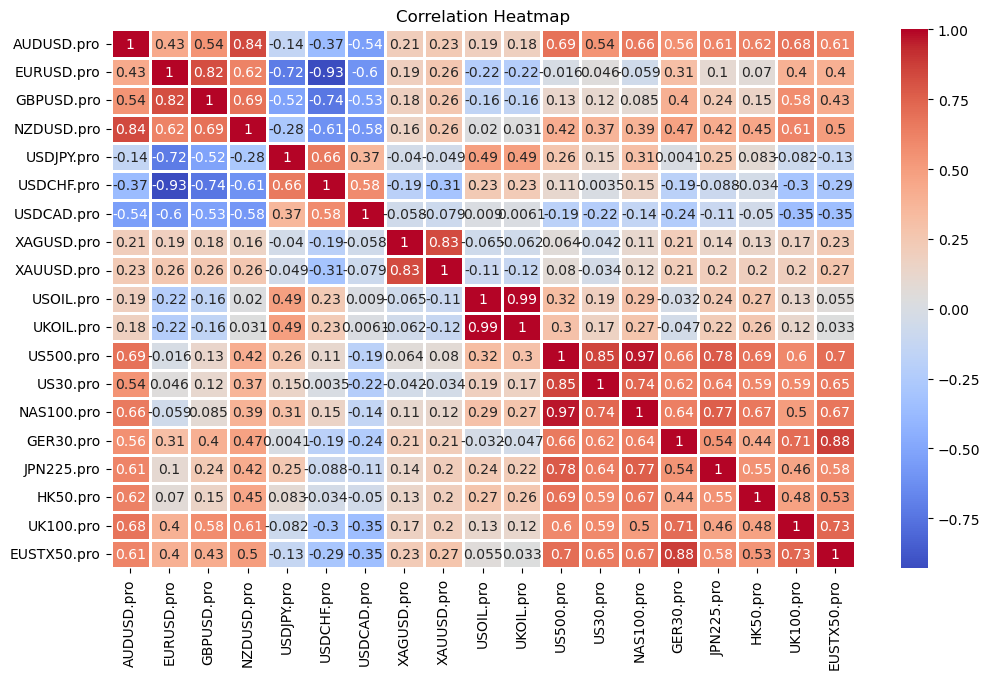

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = returns.corr()

plt.figure(figsize=(12, 7))
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.8)
plt.title("Correlation Heatmap")
plt.show()

### Volatility Targeted Weights using EWMA estimates

In [162]:
import pandas as pd
import numpy as np

# --- Load weights from comma-separated file ---
weights_df = pd.read_csv(
    "acg_optimal_portfolio_weights.csv",
    sep=",",
    header=None,
    engine="python",
    encoding="utf-8-sig"
)

weights_df.columns = ["asset", "weight"]

# Align weights to returns.columns order
weights_df = weights_df.set_index("asset").reindex(returns.columns)

# Extract weight vector
weights = weights_df["weight"].values

print("Loaded weights (aligned):")
print(weights)
print("\nAsset order:")
print(list(returns.columns))

# ============================================================
# --- EWMA COVARIANCE MATRIX ---
# ============================================================

lambda_ = 0.94  # RiskMetrics default
rets = returns.values
n = rets.shape[1]

# Start with sample covariance as initial value
ewma_cov = returns.cov().values.copy()

# Iterate through returns to update EWMA covariance
for t in range(1, len(rets)):
    r = rets[t-1].reshape(-1, 1)
    ewma_cov = lambda_ * ewma_cov + (1 - lambda_) * (r @ r.T)

# Portfolio EWMA volatility
ewma_daily_vol = np.sqrt(weights.T @ ewma_cov @ weights)
ewma_annual_vol = ewma_daily_vol * np.sqrt(252)

print("\n--- EWMA VOLATILITY FORECAST ---")
print(f"EWMA Daily Volatility: {ewma_daily_vol:0.2%}")
print(f"EWMA Annual Volatility: {ewma_annual_vol:0.2%}")

# ============================================================
# --- SCALE PORTFOLIO TO TARGET VOLATILITY USING EWMA ---
# ============================================================

target_vol = 0.05  # 5% annual volatility

scale_factor = target_vol / ewma_annual_vol
scaled_weights = weights * scale_factor

# Recompute volatility after scaling
scaled_daily_vol = np.sqrt(scaled_weights.T @ ewma_cov @ scaled_weights)
scaled_annual_vol = scaled_daily_vol * np.sqrt(252)

# Compute scaled returns
scaled_daily_returns = returns @ scaled_weights
scaled_avg_daily_return = scaled_daily_returns.mean()
scaled_annual_return = scaled_avg_daily_return * 252

print(f"\n--- SCALED PORTFOLIO (Target Vol = {target_vol:.0%}) ---")
print(f"Scale Factor: {scale_factor:.4f}")
print(f"Scaled Daily Volatility (EWMA): {scaled_daily_vol:0.2%}")
print(f"Scaled Annual Volatility (EWMA): {scaled_annual_vol:0.2%}")
print(f"Scaled Daily Portfolio Return: {scaled_avg_daily_return:0.2%}")
print(f"Scaled Annual Portfolio Return: {scaled_annual_return:0.2%}")

print("\nScaled Weights:")
for asset, w in zip(returns.columns, scaled_weights):
    print(f"{asset}: {w:.6f}")

# --- EXPORT SCALED WEIGHTS TO CSV ---
scaled_df = pd.DataFrame({
    "asset": returns.columns,
    "scaled_weight": scaled_weights
})

scaled_df.to_csv("acg_scaled_weights.csv", index=False)
print("\nScaled weights exported to acg_scaled_weights.csv")

Loaded weights (aligned):
[ 2.17641348e-01  3.61139179e-01  3.73195256e-02 -2.75403878e-02
  1.61416193e-01  1.71600705e-01  2.07995911e-01  2.86234453e-04
 -1.23325912e-02 -2.04526540e-02 -4.19651473e-02  5.94233036e-02
  3.99925231e-03 -9.93058210e-02 -2.97695981e-02 -1.44770426e-02
 -6.79040204e-02  9.29256107e-02]

Asset order:
['AUDUSD.pro', 'EURUSD.pro', 'GBPUSD.pro', 'NZDUSD.pro', 'USDJPY.pro', 'USDCHF.pro', 'USDCAD.pro', 'XAGUSD.pro', 'XAUUSD.pro', 'USOIL.pro', 'US500.pro', 'US30.pro', 'NAS100.pro', 'GER30.pro', 'JPN225.pro', 'HK50.pro', 'UK100.pro', 'EUSTX50.pro']

--- EWMA VOLATILITY FORECAST ---
EWMA Daily Volatility: 0.05%
EWMA Annual Volatility: 0.87%

--- SCALED PORTFOLIO (Target Vol = 5%) ---
Scale Factor: 5.7606
Scaled Daily Volatility (EWMA): 0.31%
Scaled Annual Volatility (EWMA): 5.00%
Scaled Daily Portfolio Return: 0.09%
Scaled Annual Portfolio Return: 23.64%

Scaled Weights:
AUDUSD.pro: 1.253752
EURUSD.pro: 2.080391
GBPUSD.pro: 0.214984
NZDUSD.pro: -0.158650
USDJPY.

### Lot Sizing

In [163]:
import pandas as pd
import MetaTrader5 as mt5
import numpy as np

# ============================
# USER CONFIG
# ============================
EQUITY = 103543.79  # set your account equity

# FX-exempt symbols (no price in formula)
FX_EXEMPT = ["USDJPY.pro", "USDCHF.pro", "USDCAD.pro"]

# Global index → FX mapping
INDEX_FX_MAP = {
    "GER30.pro": "EURUSD.pro",
    "JPN225.pro": "USDJPY.pro",
    "HK50.pro": "USDHKD.pro",
    "UK100.pro": "GBPUSD.pro",
    "EUSTX50.pro": "EURUSD.pro"
}

# ============================
# MT5 INITIALIZATION
# ============================
mt5.initialize()

def get_latest_price(symbol):
    tick = mt5.symbol_info_tick(symbol)
    if tick is None:
        return None
    return tick.ask

def fetch_prices(assets):
    return {a: get_latest_price(a) for a in assets}

def fetch_index_fx_rates():
    return {idx: get_latest_price(fx) for idx, fx in INDEX_FX_MAP.items()}

# ============================
# LOAD CSV FILES
# ============================
contract_df = pd.read_csv("acg_contract_size.csv")
weights_df = pd.read_csv("acg_scaled_weights.csv")

# Normalize column names
contract_df.columns = contract_df.columns.str.strip().str.lower()
weights_df.columns = weights_df.columns.str.strip().str.lower()

# Rename scaled_weight → weight
weights_df.rename(columns={"scaled_weight": "weight"}, inplace=True)

# Merge contract sizes + weights
df = contract_df.merge(weights_df, on="asset", how="left")

# ============================
# FETCH PRICES FROM MT5
# ============================
all_assets = df["asset"].tolist()
latest_prices = fetch_prices(all_assets)
index_fx_rates = fetch_index_fx_rates()

df["latest_price"] = df["asset"].map(latest_prices)

# ============================
# LOT SIZE CALCULATION
# ============================
def compute_lot(row):
    asset = row["asset"]
    weight = row["weight"]
    contract_size = row["contract_size"]
    price = row["latest_price"]

    # Missing weight or contract size
    if pd.isna(weight) or pd.isna(contract_size):
        return None

    # Contract size cannot be zero
    if contract_size == 0:
        return None

    # Rule 1: FX-exempt assets
    if asset in FX_EXEMPT:
        return (weight * EQUITY) / contract_size

    # Missing or zero price
    if price is None or price == 0:
        return None

    # Rule 2: Global index → convert to USD
    if asset in INDEX_FX_MAP:
        fx_rate = index_fx_rates.get(asset)
        if fx_rate is None or fx_rate == 0:
            return None
        # Invert FX rate for HK50 and JP225
        if asset in ["HK50.pro", "JPN225.pro"]:
            fx_rate = 1 / fx_rate

        price = price * fx_rate

        # After conversion, price still cannot be zero
        if price == 0:
            return None

    # Final safety check
    denominator = price * contract_size
    if denominator == 0:
        return None

    return (weight * EQUITY) / denominator

df["lot_size"] = df.apply(compute_lot, axis=1)

# ============================
# OUTPUT
# ============================
print(df[["asset", "weight", "contract_size", "latest_price", "lot_size"]].dropna())
df[["asset", "weight", "contract_size", "latest_price", "lot_size"]]\
    .dropna()\
    .to_csv("acg_lot_sizes_output.csv", index=False)

# ============================
# GROSS TOTAL LOT SIZE
# ============================
df["abs_lot_size"] = df["lot_size"].abs()
gross_total_lot_size = df["abs_lot_size"].sum()

print(f"\nGross Total Lot Size (absolute): {gross_total_lot_size:.4f}")
mt5.shutdown()

          asset    weight  contract_size  latest_price  lot_size
0    AUDUSD.pro  1.253752         100000       0.66869  1.941382
1    EURUSD.pro  2.080391         100000       1.16307  1.852094
2    GBPUSD.pro  0.214984         100000       1.33987  0.166138
3    NZDUSD.pro -0.158650         100000       0.57308 -0.286648
4    USDJPY.pro  0.929860         100000     157.95700  0.962812
5    USDCHF.pro  0.988529         100000       0.80124  1.023560
6    USDCAD.pro  1.198188         100000       1.39185  1.240650
8    XAGUSD.pro  0.001649           5000      79.98500  0.000427
9    XAUUSD.pro -0.071044            100    4510.34000 -0.016309
10    USOIL.pro -0.117820            100      58.68300 -2.078891
12    US500.pro -0.241746              1    6968.23000 -3.592201
13     US30.pro  0.342316              1   49536.81000  0.715522
14   NAS100.pro  0.023038              1   25780.54000  0.092530
15    GER30.pro -0.572065              1   25304.76000 -2.012616
16   JPN225.pro -0.171492

True

### Fetch Latest Price

In [18]:
import pandas as pd
import MetaTrader5 as mt5

# -----------------------------------------------------------
# 1. LOAD EXPECTED RETURNS FROM CSV (NO HEADER)
# -----------------------------------------------------------

expected_returns_df = pd.read_csv("ai_factor_signal_acg.csv", sep="\t", header=None)
expected_returns_dict = dict(zip(expected_returns_df[0], expected_returns_df[1]))

# -----------------------------------------------------------
# 2. INITIALIZE MT5
# -----------------------------------------------------------

# Initialize MT5 connection
from dotenv import load_dotenv
import os

load_dotenv()

login = int(os.getenv("ACG_MT5_LOGIN"))
password = os.getenv("ACG_MT5_PASSWORD")
server = os.getenv("ACG_MT5_SERVER")

if not mt5.initialize(login=login, password=password, server=server):
    print("initialize() failed, error code =", mt5.last_error())
    quit()

# -----------------------------------------------------------
# 3. FETCH LATEST PRICES
# -----------------------------------------------------------

latest_prices = {}

for asset in expected_returns_dict.keys():

    mt5.symbol_select(asset, True)
    tick = mt5.symbol_info_tick(asset)

    if tick is None:
        latest_prices[asset] = None
        print(f"Failed to fetch price for {asset}")
    else:
        latest_prices[asset] = tick.bid

# -----------------------------------------------------------
# 4. BUILD DATAFRAME
# -----------------------------------------------------------

df_prices = pd.DataFrame({
    "Asset": list(latest_prices.keys()),
    "LatestPrice": list(latest_prices.values()),
})

print(df_prices)

# -----------------------------------------------------------
# 5. SAVE TO CSV
# -----------------------------------------------------------

df_prices.to_csv("latest_prices_acg.csv", index=False)

# -----------------------------------------------------------
# 6. SHUT DOWN MT5
# -----------------------------------------------------------

mt5.shutdown()

          Asset  LatestPrice
0    AUDUSD.pro      0.66859
1    EURUSD.pro      1.16300
2    GBPUSD.pro      1.33976
3    NZDUSD.pro      0.57296
4    USDJPY.pro    157.94600
5    USDCHF.pro      0.80114
6    USDCAD.pro      1.39167
7    XAGUSD.pro     79.94000
8    XAUUSD.pro   4509.91000
9     USOIL.pro     58.64000
10    UKOIL.pro     62.74200
11    US500.pro   6967.11000
12     US30.pro  49529.00000
13   NAS100.pro  25778.69000
14    GER30.pro  25302.46000
15   JPN225.pro  53536.60000
16     HK50.pro  26329.90000
17    UK100.pro  10154.32000
18  EUSTX50.pro   6007.02000


True